In [1]:
import glob
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import copy

from IPython import display as ipd
from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder,  DatasetFolder,VisionDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import os
import torchvision.models as models

%matplotlib inline
warnings.filterwarnings("ignore")

import torchaudio
#from pydub import AudioSegment
from IPython import display
import random

C:\Users\79671\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\79671\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = False
    FULL_DATA     = True
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b1'
    archive_name  = 'Audio'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 32
    valid_bs      = 32
    width         = 100
    SAMPLE_RATE   = 16000
    NUM_SAMPLES   = 48000
    num_item_all  = 10 if DEBUG else 611800      #611829
    num_test      = 10 if DEBUG else 301      # 1000
    print_every   = 1  if DEBUG else 50      #500
    epochs        = 2  if DEBUG else 30        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    criterion = nn.CrossEntropyLoss()
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 2
    classes       = [0,1]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    test_path     = "../input/russian-railways-2/test/test/" if Kaggle else "E:/Audio/ASV/clips/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    train_path    = "E:/Audio/ASV/clips/"
    csv_path      = 'E:/Audio/ASV/valid' # '../../Испытание на стажировки/'
    best_model_w  = '../input/russian-railways-2/best_epoch_ofu-efficientnet-b4_v2.bin' if Kaggle else f'./best_epoch_ofu-{backbone}_v2.bin'


# Audio Instalations

In [3]:
#!pip install pydub

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
#waveform, sample_rate = torchaudio.load('./train/000ad36ce0dcbc1032a606312d5e787d.wav')

In [6]:
#display.Audio(waveform, rate = sample_rate)

In [7]:
#waveform.size()[0]

In [8]:
#Mel_Spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

In [9]:
#Mel_Spectrogram.shape

In [10]:
#!pip install PySoundFile

In [11]:
# Different classes dataset. 
classes = ('0','1')

In [12]:

data = pd.read_csv(CFG.csv_path, sep = '\t' ) #pd.read_csv(CFG.csv_path, sep = '\\t', header=None)

In [13]:
#data = data.rename(columns={0: "Name", 1: "Target"})

In [14]:
#data = pd.concat([data['path'] , data['fake']] , axis = 1)

In [15]:
#data = data.dropna()

In [16]:
data.head(50)

,path,fake
0,DF_E_2000011,1
1,DF_E_2000013,1
2,DF_E_2000024,1
3,DF_E_2000026,1
4,DF_E_2000027,1
5,DF_E_2000028,1
6,DF_E_2000031,1
7,DF_E_2000032,1
8,DF_E_2000040,1
9,DF_E_2000042,1


In [17]:
data.columns

Index(['path', 'fake'], dtype='object')

In [18]:
 data.shape

(611829, 2)

In [19]:
sum(data['fake'].isnull())

0

In [20]:
#from torchaudio.io import StreamReader
from IPython import display

In [21]:
# audio_ids = list(data[1])
# audio_names = list(data[0])
# print(audio_ids)

In [22]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length = 1024,
    hop_length=256,
    n_mels=80,
    window_fn = torch.hann_window,
    center=False
)

In [23]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                lable = False):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.lable = lable

    def __len__(self):
        return len(self.audio_dir)

    def __getitem__(self, index):
        #print(index)
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self.transformation(signal)
        #signal = signal[:, :, 0:CFG.width]
        #signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = signal.repeat(3, 1, 1)
        #signal = torch.squeeze(signal)
        #signal = self.transformation(signal)
        if self.lable == True: # WHEN WE TRAIN
            label = self._get_audio_sample_label(index)
            return signal, label
        else: # WHEN WE PREDICT
            return signal, torch.randint(0, 1, (1,))

    def _cut_if_necessary(self, signal):
        if signal.shape[2] > CFG.width:
            signal = signal[:, :, 0:CFG.width]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[2]
        if length_signal < CFG.width:
            num_missing_samples = CFG.width - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = self.audio_dir[index]
        if self.lable == True:
            path = os.path.join(CFG.train_path,path)
        else:
            path = os.path.join(CFG.test_path,path)
        path = path + '.flac'
        return path

    def _get_audio_sample_label(self, index):
        path = self.audio_dir[index]
        #print(path)
        df = self.annotations
        df = df.loc[lambda df: df['path'] == path]
        #print(df.head())
        num = list(df['fake'])
        #print(num)
        return torch.Tensor(num)


# if __name__ == "__main__":
#     ANNOTATIONS_FILE = "/home/valerio/datasets/UrbanSound8K/metadata/UrbanSound8K.csv"
#     AUDIO_DIR = "/home/valerio/datasets/UrbanSound8K/audio"
#     SAMPLE_RATE = 22050
#     NUM_SAMPLES = 22050

#     mel_spectrogram = torchaudio.transforms.MelSpectrogram(
#         sample_rate=SAMPLE_RATE,
#         n_fft=1024,
#         hop_length=512,
#         n_mels=64
#     )

#     usd = UrbanSoundDataset(ANNOTATIONS_FILE,
#                             AUDIO_DIR,
#                             mel_spectrogram,
#                             SAMPLE_RATE,
#                             NUM_SAMPLES)
#     print(f"There are {len(usd)} samples in the dataset.")
#     signal, label = usd[1]

In [24]:
# def clearing_names(audio_names : list, data) :
#     for audio in enumerate(audio_names):
#         if audio not in data:
#             audio_names.remove(audio)
#     return audio_names, data

In [25]:
# audio_names= [os.path.join(CFG.train_path,item_name) for item_name in os.listdir(CFG.train_path)]

In [26]:
# audio_names


In [27]:
# good_names = []
# bad_names = []
# good_names = [try for item_name in audio_names]
# for ind, name in enumerate(audio_names):

In [28]:
# good_names = []
# bad_names = []
# for ind, name in enumerate(audio_names):
#     try:
#         torchaudio.load(name)
#         good_names.append(name)
#         print(ind)
#     except Exception:
#         bad_names.append(name)

In [29]:
# len(good_names) , len(bad_names)

In [30]:
# gn = good_names

In [31]:
# gn = [item_name.split('s/')[1] for item_name in gn ]

In [32]:
# gn = [item_name.split('.')[0] for item_name in gn ]

In [33]:
# df = pd.DataFrame({'Names':gn})

In [34]:
# df.head()

In [35]:
# audio_names = pd.read_csv('./good_names',header=None, index_col=False)

In [36]:
# audio_names = list(audio_names[0])

In [37]:
# audio_names

In [38]:
# lol

In [39]:
# df.to_csv('good_names', index=False,header = False )

In [40]:
def prepare_loaders():
    audio_names = pd.read_csv(CFG.csv_path, sep = '\t' )
    audio_names = list(audio_names['path'])
    #audio_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.train_path)] #[os.path.join("./train/",item_name)  for item_name in os.listdir(CFG.train_path)]
    random.shuffle(audio_names)
    audio_names = audio_names[:CFG.num_item_all]
    print(len(audio_names))
    audio_train_valid, audio_test = train_test_split(audio_names, test_size=0.2 , random_state=42)
    audio_train, audio_valid = train_test_split(audio_train_valid, test_size=0.25 , random_state=42)
    #print(type(train_ids))
    #print(valid_ids)
    train_dataset = UrbanSoundDataset(data, audio_train, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    valid_dataset = UrbanSoundDataset(data, audio_valid, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, True)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

## Audio Augmentations

In [41]:

# transformations = transforms.Compose(
#     ProcessChannels(mode=avg)
#     AdditiveNoise(prob=0.3, sig=0.001, dist_type=normal)
#     RandomCropLength(prob=0.4, sig=0.25, dist_type=half)
#     ToTensorAudio()
# )
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=CFG.SAMPLE_RATE,
    n_fft=1024,
    win_length = 1024,
    hop_length=256,
    n_mels=80,
    window_fn = torch.hann_window,
    center=True
)



     

## Fit EfficientNet

In [42]:
def Melspectrogram_visualize(array: torch.Tensor):
    #print(array.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(array.squeeze().log())
    plt.xlabel('Time', size=20)
    plt.ylabel('Frequency (Hz)', size=20)
    plt.show()

    
    
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [43]:
from typing import List , Tuple

In [44]:
train_loader, valid_loader = prepare_loaders()

611800


In [45]:
len(train_loader) , len(valid_loader)

(11472, 3824)

In [46]:
audio = next(iter(train_loader))
#print(audio['wav'].shape)
#print(Class)


In [47]:
mel = audio[0][0]

In [48]:
mel.shape

torch.Size([3, 80, 100])

Text(0, 0.5, 'Mels')

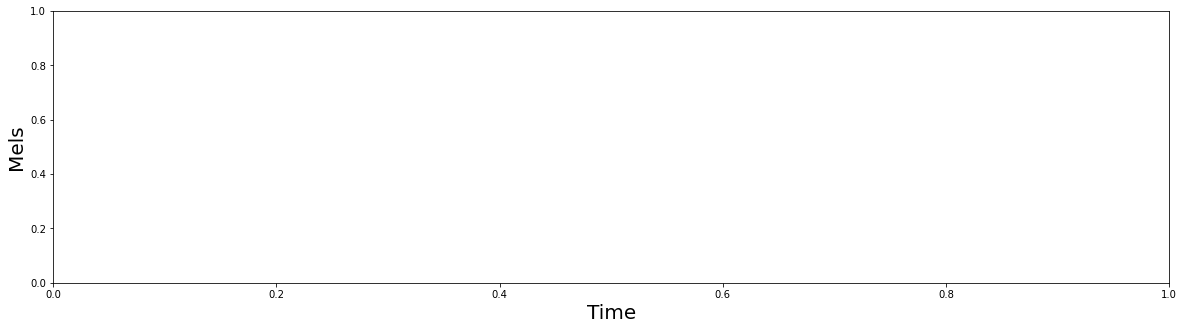

In [49]:
plt.figure(figsize=(20, 5))
#plt.imshow(mel.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
#plt.show()

In [50]:
#Melspectrogram_visualize(audio)

In [51]:
#!pip install --upgrade efficientnet-pytorch

In [52]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b1'
model = EfficientNet.from_pretrained(model_name)  #, num_classes=3
model.eval()

Loaded pretrained weights for efficientnet-b1


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [53]:
class ResNetBlock(nn.Module):
    def __init__(self, in_depth, depth, first=False):
        super(ResNetBlock, self).__init__() # super(subclass) - we will inheritance fron superclass of subclass в данном случае можно было прсто написать super()
        self.first = first
        self.conv1 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(depth)
        self.lrelu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(depth, depth, kernel_size=3, stride=3, padding=1)
        self.conv11 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=3, padding=1)
        if not self.first :
            self.pre_bn = nn.BatchNorm2d(in_depth)

    def forward(self, x):
        # x is (B x d_in x T)
        prev = x
        prev_mp =  self.conv11(x)
        if not self.first:
            out = self.pre_bn(x)
            out = self.lrelu(out)
        else:
            out = x
        out = self.conv1(x)
        # out is (B x depth x T/2)
        out = self.bn1(out)
        out = self.lrelu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        # out is (B x depth x T/2)
        out = out + prev_mp
        return out
    
class MFCCModel(nn.Module):
    def __init__(self):
        super(MFCCModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.block1 = ResNetBlock(32, 32,  True)
        self.mp = nn.MaxPool2d(3, stride=3, padding=1)
        self.block2 = ResNetBlock(32, 32,  False)
        self.block3 = ResNetBlock(32, 32,  False)
        self.block4= ResNetBlock(32, 32, False)
        self.block5= ResNetBlock(32, 32, False)
        self.block6 = ResNetBlock(32, 32, False)
        self.block7 = ResNetBlock(32, 32, False)
        self.block8 = ResNetBlock(32, 32, False)
        self.block9 = ResNetBlock(32, 32, False)
        self.lrelu = nn.LeakyReLU(0.01)
        self.bn = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(dim=1)
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.mp(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.mp(out)
        out = self.block7(out)
        out = self.block8(out)
        out = self.block9(out)
        out = self.bn(out)
        out = self.lrelu(out)
        out = self.mp(out)
        out = out.view(batch_size, -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.lrelu(out)
        out = self.fc2(out)
        out = self.logsoftmax(out)
        return out
    

In [54]:
device = CFG.device

model = EfficientNet.from_pretrained(model_name).to(device)  #, num_classes=3
#model = MFCCModel().to(device)
#featurizer = Featurizer().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b1


In [55]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [56]:
import shutil, os

try:
    if CFG.Kaggle:
        os.mkdir('../working/result')
        print('KAGGLE DIR CREATED')
    else:
        shutil.rmtree('./result')
        os.mkdir('./result')
        print('PC DIR CREATED')
except Exception:
    print("DIR NOT CREATED")
    pass

PC DIR CREATED


In [57]:
from collections import defaultdict

In [58]:
storage = defaultdict(list)

In [59]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size # sum of sizes 
    all_scores = np.concatenate((target_scores, nontarget_scores)) # vector of scores
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size))) # vextor of labels
    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort') # retern indexes of sorted array of zeros and ones
    labels = labels[indices] # and sort labels like (zeros and ones) for all 0 in both arrays and (zeros + ones) of 1 in both arrays

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels) # array with max element N
    # (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums | gives array of element with max el = N
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1, step = 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds
def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs) # return index of min element
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

In [ ]:
for epoch in range(CFG.epochs):
    print(f'Epoch: {epoch + 1} ')
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        #print(f'label:{label}')
        wav = wav.squeeze()
        #mel, mel_length = featurizer(wav, length)
        output = model(wav)
        #print(output)
        #print(f'output :{output.argmax(dim=-1)}')
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
###################################################################################################################
#############################################  Validation  ########################################################
###################################################################################################################

    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()
    validation_f1_meter = AverageMeter()
    validation_EER_meter = AverageMeter()
    #all_matrix = [[0,0],[0,0]]
    model.eval()
    for i, batch in enumerate(tqdm(valid_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch[0].to(device)
        #length = batch['length'].to(device)
        label = batch[1].to(device)
        label = label.reshape(len(label))
        label = torch.tensor(label).long()
        wav = wav.squeeze()
        with torch.no_grad():

            #mel, mel_length = featurizer(wav, length)
            output = model(wav)

            loss = criterion(output, label)
            out = output.argmax(dim=-1).cpu().numpy()
            labels = label.cpu().numpy()
        #print(f'output :{output.argmax(dim=-1)}, label : {label}')
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        f1 = f1_score(output.argmax(dim=-1).cpu(), label.cpu(), average= 'weighted')
        eer = compute_eer(labels,out)
        validation_EER_meter.update(eer[0])
        validation_f1_meter.update(f1)
        #matrix = confusion_matrix(labels,out)
        #all_matrix+=matrix
        print(f'F1 :{f1} , EER: {eer}')
        #print(f'Confusion Matrix of all:{all_matrix}')
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    storage['validation_F1_score'].append(validation_f1_meter.avg)
    storage['validation_EER'].append(validation_EER_meter.avg)
    display.clear_output()
    #print(f'Confusion Matrix of all:{all_matrix}')
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')
    
    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')
    axes[3].plot(storage['validation_F1_score'], label='validation_F1_score')
    axes[4].plot(storage['validation_EER'], label='EER')
    for i in range(5):
        axes[i].grid()
        axes[i].legend()

    plt.show()


Epoch: 1 


  0%|          | 0/11472 [00:00<?, ?it/s]

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
PATH = f"./result/ebest_epoch_ofeffnet_b1.bin"
torch.save(model.state_dict(), PATH)

In [ ]:
f.close()

In [ ]:
matrix

In [ ]:
all_matrix = [[0,0],[0,0]]

In [ ]:
all_matrix+=matrix

In [ ]:
all_matrix


In [ ]:
storage['validation_F1_score']
    

In [ ]:
f1_score(out.cpu(),label.cpu(),average='weighted')

In [ ]:
#fit(model, CFG.epochs , train_loader, valid_loader, optimizer, CFG.criterion, CFG.device)

## Efficcient_net predict

In [ ]:
#test = []
'./test/'
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]#os.path.join("./test",item_name)
test_dataset = UrbanSoundDataset(data, items_names, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES, False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True, drop_last=False,collate_fn=Collator())


In [ ]:
test = []
for i, batch in enumerate(tqdm(test_loader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)
            #print(output)
            _, pred = torch.max(output, 1) # Return values and indices
            #m = nn.Softmax(dim=1)
            #pred = m(output)
            #print(pred)
            #print(pred.item())
            #df
            test.append(classes[pred.item()])
#print(test)

In [ ]:
print(len(test))

In [ ]:
items_names= [item_name.split('.')[0] for item_name in os.listdir(CFG.test_path)]

In [ ]:
df = pd.DataFrame({"id" :items_names,
                   "eff": test
        
                  })

In [ ]:
df.head(2)

In [ ]:

ansamble_pred = df['eff'].to_numpy()

In [ ]:
#df.to_csv?

In [ ]:
print('Generating submission file...')
#os.chdir("./")
df.to_csv('answers.tsv',index=False, sep = '\t',header = False)

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": ansamble_pred
# #                   }

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": test
#                   })

In [ ]:
# df["class"]

In [ ]:
# df.tail(50)

In [ ]:
# df_full.tail(50)

In [ ]:
# print('Generating submission file...')
#os.chdir("./")
# df.to_csv('submission_audio.csv',index=False)

In [ ]:
# df_full.to_csv('submission_effnet7new2.csv',index=False)